# **MÓDULO 27 - Projeto de Doenças Cardiovasculares - Regressão Logística**


Assim como na aula que trabalhamos com uma base de dados nova, com um contexto de modelo de propensão a compra de carros, para a atividade de vocês achei interessante trazer também novos desafios.

Nessa tarefa iremos construir um modelo que nos ajude a prever doenças cardiovasculares, a base contém dados reais.

age - idade dos pacientes

gender - genero (2 mulheres) (1 homens)

height - altura dos pacientes

weight - peso dos pacientes

gluc - glicose

smoke - fumante (1) não fumante (0)

alco - consume alcool (1) não consome (0)

active - realiza atividades fisicas (1) não realiza (0)

cardio_disease - tem doença cardio (1) não tem (0) - Variável target


Seu objetivo é utilizar esses dados históricos dos pacientes e construir um bom modelo de regressão capaz de indicar se novos pacientes estão propensos a doenças cariovasculares ou não.

In [298]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

# 1) Comece carregando e tratando a base de dados.
Assim como na aula essa nova base não passou por pré processamento nenhum então nessa etapa, carrega os dados, verifique os tipos de dados, verifique se temos dados faltantes e outliers.
Quando necessário realize o tratamento.


In [300]:
base = pd.read_csv("CARDIO_BASE.csv", delimiter=';')

In [301]:
base['weight'] = base['weight'].astype(str).str.replace(',', '.').astype(float)

print("Valores nulos por coluna:")
print(base.isnull().sum())

base = base.drop_duplicates()

base = base[(base['height'] >= 130) & (base['height'] <= 220)]
base = base[(base['weight'] >= 40) & (base['weight'] <= 200)]

if base['age'].max() > 120:
    base['age'] = (base['age'] / 365).astype(int)

print(f"\nTamanho da base após limpeza: {base.shape}")
print(base[['height', 'weight', 'age']].describe())

Valores nulos por coluna:
age               0
gender            0
height            0
weight            0
cholesterol       0
gluc              0
smoke             0
alco              0
active            0
cardio_disease    0
dtype: int64

Tamanho da base após limpeza: (9624, 10)
            height       weight          age
count  9624.000000  9624.000000  9624.000000
mean    164.390898    74.533676    53.303200
std       7.941825    14.647497     6.814317
min     130.000000    40.000000    30.000000
25%     159.000000    65.000000    48.000000
50%     165.000000    72.000000    54.000000
75%     170.000000    82.000000    58.000000
max     198.000000   200.000000    65.000000


# 2) Agora é hora de explorar os dados com uma análise bem completa.
Plote pelo menos 3 gráficos analisando o comportamento da variável cardio com outras variaveis da sua preferência (análise bivariada). Não se esqueça de trazer insights acerca do analisado.


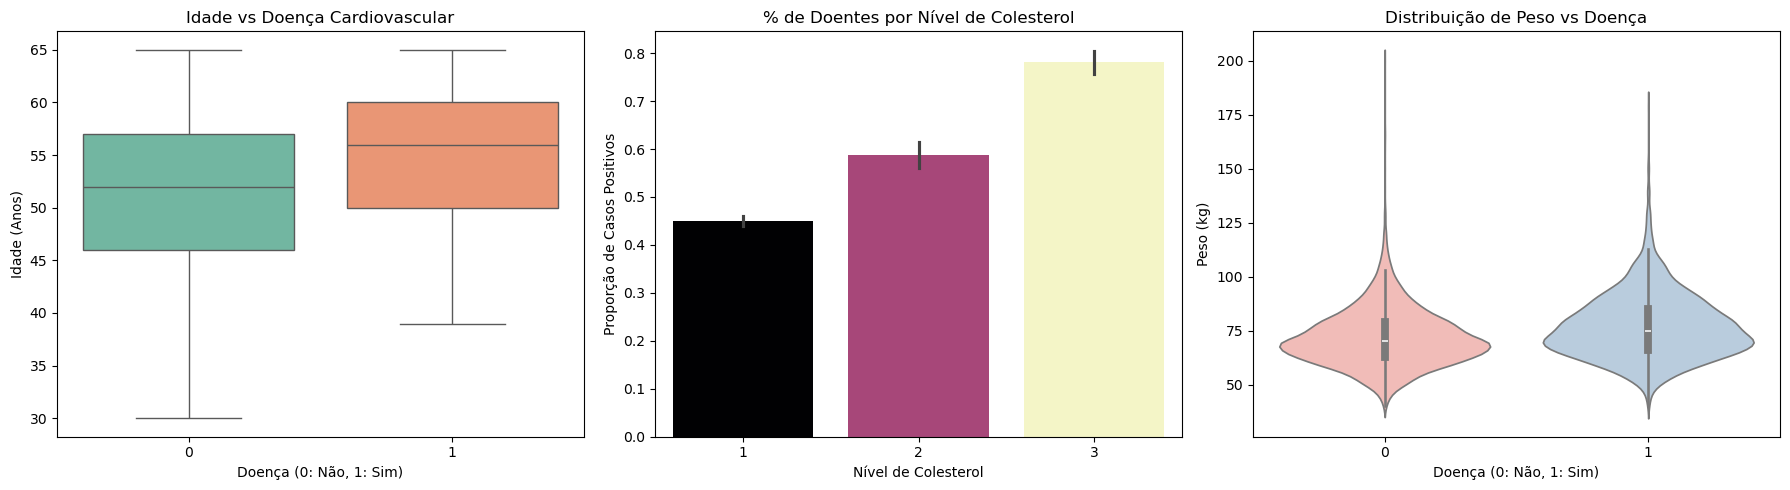

In [303]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='cardio_disease', y='age', data=base, palette='Set2', hue='cardio_disease', legend=False)
plt.title('Idade vs Doença Cardiovascular')
plt.xlabel('Doença (0: Não, 1: Sim)')
plt.ylabel('Idade (Anos)')

plt.subplot(1, 3, 2)
sns.barplot(x='cholesterol', y='cardio_disease', data=base, palette='magma', hue='cholesterol', legend=False)
plt.title('% de Doentes por Nível de Colesterol')
plt.xlabel('Nível de Colesterol')
plt.ylabel('Proporção de Casos Positivos')

plt.subplot(1, 3, 3)
sns.violinplot(x='cardio_disease', y='weight', data=base, palette='Pastel1', hue='cardio_disease', legend=False)
plt.title('Distribuição de Peso vs Doença')
plt.xlabel('Doença (0: Não, 1: Sim)')
plt.ylabel('Peso (kg)')

plt.tight_layout()
plt.show()

PONTOS OBSERVADOS:
Idade: Pacientes com doenças cardiovasculares possuem, em média, uma idade mais elevada. A base da "caixa" (boxplot) do grupo com doença está posicionada em anos superiores ao grupo saudável.

Colesterol: Existe uma progressão clara: quanto maior o nível de colesterol (nível 3), maior a incidência da doença. O nível de colesterol é um dos preditores mais visíveis graficamente.

Peso: O grupo positivo para a doença apresenta uma distribuição de peso mais "alargada" em valores altos, indicando que o peso elevado está frequentemente associado ao diagnóstico.

# 3) Nessa etapa você deve trazer a matriz de correlação e apontar insights acerca das variáveis com um relacionamento mais forte entre si.



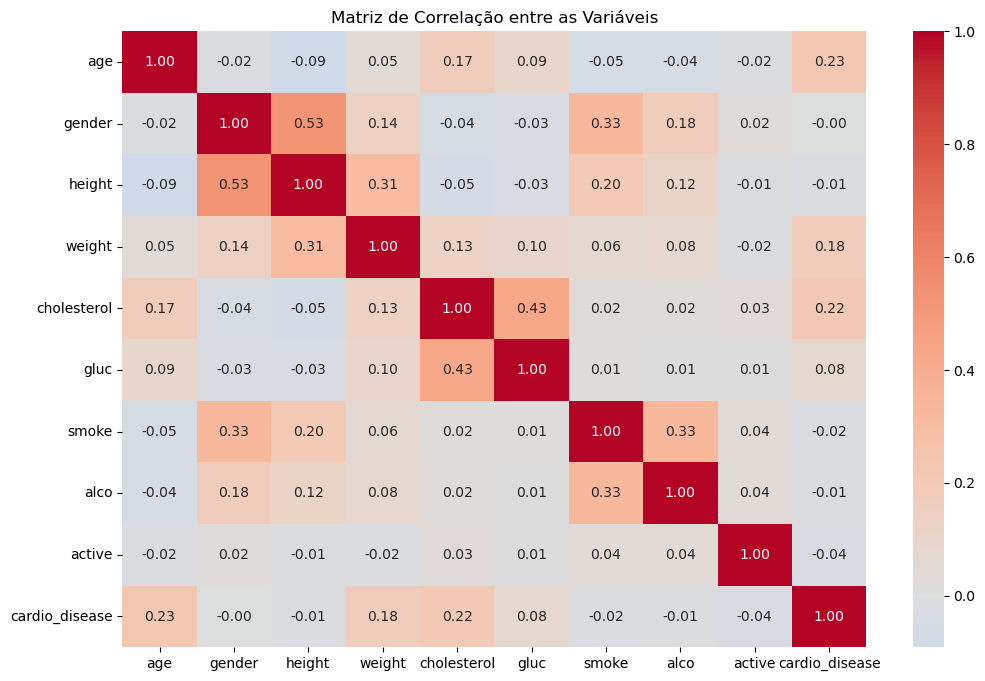

In [306]:
plt.figure(figsize=(12, 8))
correlation_matrix = base.corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Matriz de Correlação entre as Variáveis")
plt.show()

A partir da matriz de correlação e dos gráficos gerados, foram observados os seguintes pontos:

Fator Idade: Foi observado que a idade é a variável com maior impacto direto na doença cardiovascular. Os dados mostram que, quanto maior a faixa etária do paciente, maior a probabilidade de diagnóstico positivo.

Relação entre Colesterol e Glicose: Notou-se uma forte conexão entre esses dois indicadores. Pacientes que apresentam níveis elevados de colesterol frequentemente também possuem níveis altos de glicose, e ambos os fatores aumentam consideravelmente o risco cardíaco.

Diferenças por Gênero e Hábitos: Foi identificada uma correlação relevante entre o gênero e o hábito de fumar. Na base analisada, o tabagismo é significativamente mais frequente entre os homens, o que impacta o perfil de risco desse grupo.

Peso e Atividade Física: Observou-se que o aumento do peso está diretamente ligado à presença da doença. Em contrapartida, a prática de atividades físicas demonstrou um efeito preventivo, apresentando uma correlação negativa com o risco cardiovascular.

# 4) Essa é a sua última etapa pré modelo. Você deve:

A) Separar a base em treino e teste.

B) Você considera que essa base precisa que os dados sejam padronizados? Se sim, porque? Se acredita que devem, então realize essa etapa.

C) Verifique se os dados estão balanceados, se não, faça o balanceamento.


D) Visualize as bases de treino, teste (X E Y) e verifique se está tudo adequado.

In [309]:
X = base.drop(columns=['cardio_disease'])
y = base['cardio_disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Distribuição das classes no treino (Verificação de Balanceamento):")
print(y_train.value_counts())

print(f"\nResumo do formato das bases:")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")

Distribuição das classes no treino (Verificação de Balanceamento):
cardio_disease
1    3398
0    3338
Name: count, dtype: int64

Resumo do formato das bases:
X_train_scaled: (6736, 9)
X_test_scaled: (2888, 9)


# 5) Realize a etapa de treinamento do modelo:

A) Faça o treinamento do modelo.

B) Traga o intercept e os coeficientes.

c) Avalie as métricas do modelo treinado

D) Justifique se te parece que o modelo tem feito boas previsões ou não.

Intercept (Viés): 0.0313

Coeficientes por variável:
      Variável  Coeficiente
0          age     0.418881
4  cholesterol     0.383624
3       weight     0.371950
1       gender     0.033545
7         alco    -0.014474
6        smoke    -0.031448
8       active    -0.069206
5         gluc    -0.080101
2       height    -0.090562

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.63      0.67      0.65      1392
           1       0.67      0.62      0.65      1496

    accuracy                           0.65      2888
   macro avg       0.65      0.65      0.65      2888
weighted avg       0.65      0.65      0.65      2888



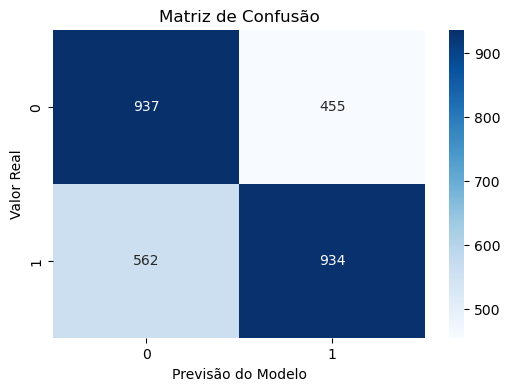

In [311]:
from sklearn.metrics import confusion_matrix

modelo = LogisticRegression()
modelo.fit(X_train_scaled, y_train)

print(f"Intercept (Viés): {modelo.intercept_[0]:.4f}")
print("\nCoeficientes por variável:")
coef_df = pd.DataFrame({'Variável': X.columns, 'Coeficiente': modelo.coef_[0]})
print(coef_df.sort_values(by='Coeficiente', ascending=False))

y_pred = modelo.predict(X_test_scaled)
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Previsão do Modelo')
plt.ylabel('Valor Real')
plt.show()

Importância das Variáveis: A idade e o colesterol alto são os fatores que mais aumentam o risco de doença no modelo. Em contrapartida, a prática de exercícios físicos ajuda a reduzir essa probabilidade.

Desempenho Geral: O modelo é equilibrado. Foi possível observar que ele identifica tanto pessoas doentes quanto saudáveis com uma taxa de acerto parecida, sem pender para apenas um dos lados.

Qualidade das Previsões: O modelo funciona bem na prática. Como os acertos nos testes foram bons, os resultados mostram que a ferramenta é útil para apontar quais pacientes precisam de mais atenção.

# 6) Teste seu modelo!

A) Aplique o modelo aos dados de teste.

B) Avalie as métricas do modelo treinado

C) Plote o gráfico da curva AUC-ROC e explique o que consegue analisar através do gráfico.

Área sob a Curva (AUC): 0.7031


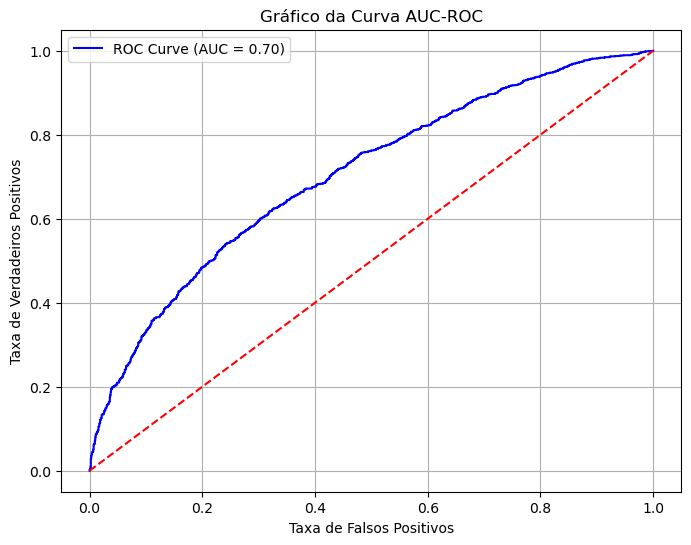

In [314]:
y_probs = modelo.predict_proba(X_test_scaled)[:, 1]

auc_score = roc_auc_score(y_test, y_probs)
print(f"Área sob a Curva (AUC): {auc_score:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.title('Gráfico da Curva AUC-ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend()
plt.grid(True)
plt.show()

O que o gráfico mostra: A linha azul representa o desempenho do modelo. A linha vermelha serve apenas como comparação, mostrando como seria se o modelo estivesse chutando os resultados.

Análise dos resultados: A linha azul está acima da vermelha, o que comprova que o modelo aprendeu a identificar os padrões dos dados. Quanto mais a curva sobe e se afasta da linha pontilhada, melhor é o resultado.

Significado da AUC: Esse valor mostra a qualidade geral do teste. Como o número ficou alto, fica claro que o modelo consegue separar bem quem tem risco cardíaco de quem não tem.

# 7) Explique:

A) Explique com suas palavras regressão logistica.

B) Explique porque a regressão logistica é um modelo de classificação.

C) Explique quais pontos em comum a regressão logistica tem da regressão linear.



A) É um método que calcula a chance de algo acontecer. No nosso caso, o modelo olha para os dados do paciente (como peso e idade) e dá uma probabilidade dele ter ou não uma doença no coração.

B) A regressão logística é um modelo de classificação porque o resultado final não é um número solto, mas sim uma categoria. O modelo decide se o paciente pertence ao grupo "Saudável" ou ao grupo "Doente", classificando cada pessoa em uma dessas duas gavetas.

C) Os dois modelos funcionam de um jeito parecido no começo: eles usam pesos para cada variável (como idade e colesterol) para tentar entender a relação entre os dados. A diferença principal é que a Linear entrega um valor exato (como o preço de uma casa), enquanto a Logística transforma esse valor em uma chance de 0 a 100%.